In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [17]:
df_data_pt_1 = pd.read_csv("Nomis Solutions_Data Part I.csv")
df_data_pt_1['car_type']=df_data_pt_1['Car  Type']
df_data_pt_1['previous_rate']=df_data_pt_1['Previous Rate']
df_data_pt_1['approve_date']=df_data_pt_1['Approve Date']
df_data_pt_1['competition_rate']=df_data_pt_1['Competition rate']
df_data_pt_1['cost_of_funds']=df_data_pt_1['Cost of Funds']


df_data_pt_1.drop(['Car  Type','Previous Rate','Approve Date','Competition rate','Cost of Funds'],axis=1,inplace=True)
df_data_pt_1.approve_date= pd.to_datetime(df_data_pt_1.approve_date)
df_data_pt_1.previous_rate = df_data_pt_1.previous_rate.apply(lambda x:0 if x == ' ' else float(x))
df_data_pt_2 = pd.read_csv("Nomis Solutions Part II.csv",skiprows=1)

## add in the year , month, and date to cluster against
df_data_pt_1['year'] = df_data_pt_1.approve_date.apply( lambda x: x.year)
df_data_pt_1['month'] = df_data_pt_1.approve_date.apply( lambda x: x.month)
df_data_pt_1['day'] = df_data_pt_1.approve_date.apply( lambda x: x.day)

## fix the naming with tier
df_data_pt_1['tier'] = df_data_pt_1.iloc[:,0]
df_data_pt_1 = df_data_pt_1.iloc[:,1:]

In [18]:
## create a dataframe without data to cluster against
df_data_copy = df_data_pt_1.copy()
df_data_pt_1_no_date = df_data_copy.loc[:,('tier', 'FICO', 'Term', 'Amount', 'Outcome', 'Rate', 'Partner Bin',\
       'car_type', 'previous_rate', 'competition_rate',\
       'cost_of_funds', 'year', 'month', 'day')]

In [19]:
# Drop NA columns
df_data_pt_1.dropna(inplace=True)


In [20]:
 #Drop na columns
df_data_pt_2.dropna(inplace=True)

In [21]:
df_data_pt_1_no_date.dropna(inplace=True)

In [22]:
df_data_pt_1_no_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208077 entries, 0 to 208078
Data columns (total 14 columns):
tier                208077 non-null float64
FICO                208077 non-null float64
Term                208077 non-null float64
Amount              208077 non-null float64
Outcome             208077 non-null float64
Rate                208077 non-null float64
Partner Bin         208077 non-null float64
car_type            208077 non-null object
previous_rate       208077 non-null float64
competition_rate    208077 non-null float64
cost_of_funds       208077 non-null float64
year                208077 non-null float64
month               208077 non-null float64
day                 208077 non-null float64
dtypes: float64(13), object(1)
memory usage: 23.8+ MB


In [23]:
df_data_no_date_dummy = pd.get_dummies(df_data_pt_1_no_date)

In [53]:
## round our values to four places
df_data_no_date_dummy = df_data_no_date_dummy.apply(lambda x:round(x,4))

In [54]:
df_data_no_date_dummy.head()

,tier,FICO,Term,Amount,Outcome,Rate,Partner Bin,previous_rate,competition_rate,cost_of_funds,year,month,day,car_type_N,car_type_R,car_type_U
0,3.0,695.0,72.0,35000.0,0.0,7.49,1.0,0.0,6.25,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0
1,1.0,751.0,60.0,40000.0,0.0,5.49,3.0,0.0,5.65,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0
2,1.0,731.0,60.0,18064.0,0.0,5.49,3.0,0.0,5.65,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0
3,4.0,652.0,72.0,15415.0,0.0,8.99,3.0,0.0,6.25,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0
4,1.0,730.0,48.0,32000.0,0.0,5.49,1.0,0.0,5.65,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0


In [26]:
# Classify the customers we have into groups
knn_classifier = KMeans()

In [27]:
predicted_labels

array([6, 6, 3, ..., 1, 1, 3], dtype=int32)

In [45]:

first_sample = df_data_no_date_dummy.sample(10000)

In [39]:
fit_knn = knn_classifier.fit(X=first_sample)
predicted_labels = fit_knn.labels_
predicted_labels

array([5, 5, 0, ..., 6, 4, 0], dtype=int32)

In [40]:
## too large for this
silhouette_score(X=first_sample,labels=predicted_labels)

0.55660832243458125

In [217]:
def sample_silhouette_score(dataframe_input,max_size=20):
    """Run a three fold CV on 20,000 samples from the dataframe to determine the ideal number of clusters.
    Output is the ideal number of clusters of 3 CV folds with 20k samples."""
    silhouette_score_l = []
    for clusters in range(2,25):
        knn_classifier = KMeans(clusters)
        silhouette_scores_for_this_cluster = []
        for _ in range(3): ## CV for samples
            sample = dataframe_input.sample(12000)
            fit_knn = knn_classifier.fit(X=sample.values)
            predicted_labels = fit_knn.labels_
            silhouette_scores_for_this_cluster.append(silhouette_score(X=sample,labels=predicted_labels))
        silhouette_score_l.append(np.mean(silhouette_scores_for_this_cluster))
        print('Finished iteration {}'.format(clusters))
    number_of_clusters = [i for i in range(2,25)]
    plt.plot([i for i in range(2,25)],silhouette_score_l)
    plt.title('Silhouette score vs Num. Clusters')
    print('The best number of clusters is {}'.format(number_of_clusters[np.argmax(np.array(silhouette_score_l))]))
        
    

Finished iteration 2
Finished iteration 3
Finished iteration 4
Finished iteration 5
Finished iteration 6
Finished iteration 7
Finished iteration 8
Finished iteration 9
Finished iteration 10
Finished iteration 11
Finished iteration 12
Finished iteration 13
Finished iteration 14
Finished iteration 15
Finished iteration 16
Finished iteration 17
Finished iteration 18
Finished iteration 19
Finished iteration 20
Finished iteration 21
Finished iteration 22
Finished iteration 23
Finished iteration 24
The best number of clusters is 20


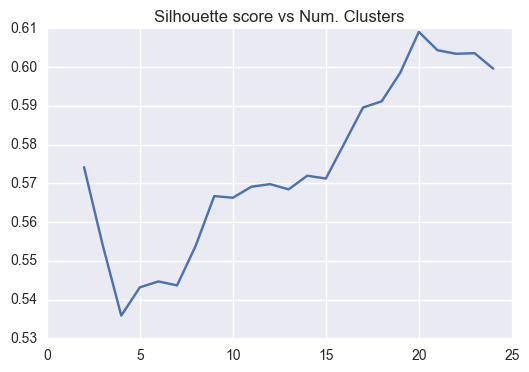

In [218]:
# This takes ~20 minutes to run
sample_silhouette_score(df_data_no_date_dummy)

- Twenty is the ideal nuber of clusters here


In [219]:
def find_avg_centroid(dataframe_input,cv=5,cluster_size=20):
    """Using 20 centers, find the averge middle value of each center.
    This will return a dict where the key is the center number, and the value is a list of the location
    of the cluster center."""
    centroids = defaultdict(list)
    
    final_centroids=defaultdict(list)
    for x in range(cv): ## CV for samples
        sample = dataframe_input.sample(15000)
        knn_classifier = KMeans(cluster_size)
        fit_knn = knn_classifier.fit(X=sample.values)
        predicted_labels = fit_knn.labels_
        for cluster_number in range(len(fit_knn.cluster_centers_)):

            centroids[cluster_number ].append(fit_knn.cluster_centers_)
            
    # next, take the average of each CV center from the clusters above
    for k,v in centroids.items():
        current_centroid_avg = []
        df = pd.DataFrame(v[0]) # conver t odf to make taking th mean easier
        #print(np.mean(df.iloc[:,0]),'here')
        
        for col_num in range(np.shape(df)[1]):
            final_centroids[k].append(  np.mean(df.iloc[:,col_num]))

            
            
            #current_centroid_avg.append(np.mean(v[:,idx]))
        #final_centroids[k]=np.mean(v)
    return final_centroids

In [221]:
average_cluster_centers = find_avg_centroid(df_data_no_date_dummy)

looP
looP
looP
looP
looP
looP
looP
looP
looP
looP
looP
looP
looP
looP
looP
looP
looP
looP
looP
looP


In [222]:
average_cluster_centers 

defaultdict(list,
            {0: [1.913806465036549,
              728.3917857671029,
              57.41030403097145,
              32898.93451231782,
              0.21008431729480237,
              5.5740383058112215,
              2.0011201141211137,
              1.6289808774981729,
              4.777911824458723,
              1.317538020060166,
              2003.2473096074693,
              6.681798283422805,
              15.685598958657357,
              0.616741915900122,
              0.19738533303296743,
              0.18587275106691192],
             1: [1.913806465036549,
              728.3917857671029,
              57.41030403097145,
              32898.93451231782,
              0.21008431729480237,
              5.5740383058112215,
              2.0011201141211137,
              1.6289808774981729,
              4.777911824458723,
              1.317538020060166,
              2003.2473096074693,
              6.681798283422805,
              15.685598958657357,
